##Task 

The task consists in decomposing an image obtained as a sum of a two images img1 and img2 into its components.

The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.

No preprocessing is allowed. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist

from keras.layers import concatenate, Input, Conv2D, Conv2DTranspose, MaxPooling2D, add
from keras.models import Model

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def display_history(history):
    mse_training = history.history['loss']

    mse_val = history.history['val_loss']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

##Dataset creation

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

# Further break training data into train / validation sets (put 5000 into validation set and keep remaining 55,000 for train)
(mnist_x_train, mnist_x_valid) = mnist_x_train[5000:], mnist_x_train[:5000] 
(mnist_y_train, mnist_y_valid) = mnist_y_train[5000:], mnist_y_train[:5000]

(fashion_mnist_x_train, fashion_mnist_x_valid) = fashion_mnist_x_train[5000:], fashion_mnist_x_train[:5000] 
(fashion_mnist_y_train, fashion_mnist_y_valid) = fashion_mnist_y_train[5000:], fashion_mnist_y_train[:5000]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
print(f"Mnist:\nTrain: {np.shape(mnist_x_train)}, Validation: {np.shape(mnist_x_valid)}, Test: {np.shape(mnist_x_test)}")
print(f"Fashion mnist:\nTrain: {np.shape(fashion_mnist_x_train)}, Validation: {np.shape(fashion_mnist_x_valid)}, Test: {np.shape(fashion_mnist_x_test)}")

Mnist:
Train: (55000, 32, 32), Validation: (5000, 32, 32), Test: (10000, 32, 32)
Fashion mnist:
Train: (55000, 32, 32), Validation: (5000, 32, 32), Test: (10000, 32, 32)


In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

In [ ]:
batchsize = 16
inputShape = (32,32,1)

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,1)
val_generator = datagenerator(mnist_x_valid,fashion_mnist_x_valid,1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

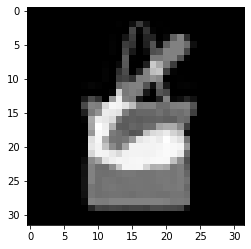

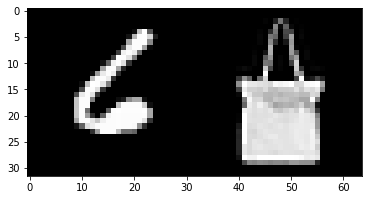

In [ ]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

## Model

After a lot of experiments with different models based on the UNet backbone (including UNet++[[1]](https://arxiv.org/abs/1912.05074), DCNet[[2]](https://pubmed.ncbi.nlm.nih.gov/32444591/) and SUnet[[3]](https://arxiv.org/abs/2202.14009)) the best results emerged with a MultiResUNet[[4]](https://arxiv.org/pdf/1902.04049.pdf)-like structure.

In particular, the model is made of an encoder and two decoders, whose output will then be concatenated to generate the desired result. 

Instead of the classical output generated for image segmentation, the model created uses instead a linear activation function to generate the output images.

The **MultiResUNet** architecture has two main characteristics:


*   *Multires blocks*, which replace the sequence of two convolutions of the classical UNet implementation. They use residual connections and convolutions with different kernel sizes to extract features from different scales. The results of 5x5 and 7x7 convolutions are simulated by a sequence of 3x3 convolutions.
*   *Respaths*, which replace the ordinary skip connections with a sequence of convolutional layers along residual connections to try to fill the semantic gap between features in the decoders and the ones in the encoder.



In [ ]:
input = Input((32,32,1))

# encoder
res1 = Conv2D(64, 1,padding="same", activation="relu")(input)
conv1_3x3 = Conv2D(round(64*0.5), (3,3), padding="same", activation="relu")(input)
conv1_5x5 = Conv2D(round(64*0.333), (3,3), padding="same", activation="relu")(conv1_3x3)
conv1_7x7 = Conv2D(round(64*0.167), (3,3), padding="same", activation="relu")(conv1_5x5)
conv1 = concatenate([conv1_3x3, conv1_5x5, conv1_7x7], axis=3)
conv1 = add([res1, conv1])
x = MaxPooling2D((2,2))(conv1)
# respath1
respath1 = add([Conv2D(64, 3, padding="same", activation="relu")(conv1), Conv2D(64, 1, padding="same", activation="relu")(conv1)])
respath1 = add([Conv2D(64, 3, padding="same", activation="relu")(respath1), Conv2D(64, 1, padding="same", activation="relu")(respath1)])
respath1 = add([Conv2D(64, 3, padding="same", activation="relu")(respath1), Conv2D(64, 1, padding="same", activation="relu")(respath1)])

res2 = Conv2D(128, 1, padding="same", activation="relu")(x)
conv2_3x3 = Conv2D(round(128*0.5), (3,3), padding="same", activation="relu")(x)
conv2_5x5 = Conv2D(round(128*0.333), (3,3), padding="same", activation="relu")(conv2_3x3)
conv2_7x7 = Conv2D(round(128*0.167), (3,3), padding="same", activation="relu")(conv2_5x5)
conv2 = concatenate([conv2_3x3, conv2_5x5, conv2_7x7], axis=3)
conv2 = add([res2, conv2])
x = MaxPooling2D((2,2))(conv2)
# respath2
respath2 = add([Conv2D(128, 3, padding="same", activation="relu")(conv2), Conv2D(128, 1, padding="same", activation="relu")(conv2)])

# middle block
resm = Conv2D(256, 1, padding="same", activation="relu")(x)
convm_3x3 = Conv2D(round(256*0.5), (3,3), padding="same", activation="relu")(x)
convm_5x5 = Conv2D(round(256*0.333), (3,3), padding="same", activation="relu")(convm_3x3)
convm_7x7 = Conv2D(round(256*0.167), (3,3), padding="same", activation="relu")(convm_3x3)
convm = concatenate([convm_3x3, convm_5x5, convm_7x7], axis=3)
convm = add([resm, convm])

# decoder 1
deconv2 = Conv2DTranspose(128, (3,3), strides=(2, 2), padding="same")(convm)
x = concatenate([deconv2, respath2])
ures2 = Conv2D(128, 1, padding="same", activation="relu")(x)
uconv2_3x3 = Conv2D(round(128*0.5), (3,3), padding="same", activation="relu")(x)
uconv2_5x5 = Conv2D(round(128*0.333), (3,3), padding="same", activation="relu")(uconv2_3x3)
uconv2_7x7 = Conv2D(round(128*0.167), (3,3), padding="same", activation="relu")(uconv2_5x5)
uconv2 = concatenate([uconv2_3x3, uconv2_5x5, uconv2_7x7], axis=3)
uconv2 = add([ures2, uconv2])
deconv1 = Conv2DTranspose(64, (3,3), strides=(2, 2), padding="same")(uconv2)
x = concatenate([deconv1, respath1])
ures1 = Conv2D(64, 1, padding="same", activation="relu")(x)
uconv1_3x3 = Conv2D(round(64*0.5), (3,3), padding="same", activation="relu")(x)
uconv1_5x5 = Conv2D(round(64*0.333), (3,3), padding="same", activation="relu")(uconv1_3x3)
uconv1_7x7 = Conv2D(round(64*0.167), (3,3), padding="same", activation="relu")(uconv1_5x5)
uconv1 = concatenate([uconv1_3x3, uconv1_5x5, uconv1_7x7], axis=3)
uconv1 = add([ures1, uconv1])
f1f = Conv2D(1, (3,3), padding="same")(uconv1)

#decoder2
deconv2 = Conv2DTranspose(128, (3,3), strides=(2, 2), padding="same")(convm)
x = concatenate([deconv2, respath2])
ures2 = Conv2D(128, 1, padding="same", activation="relu")(x)
uconv2_3x3 = Conv2D(round(128*0.5), (3,3), padding="same", activation="relu")(x)
uconv2_5x5 = Conv2D(round(128*0.333), (3,3), padding="same", activation="relu")(uconv2_3x3)
uconv2_7x7 = Conv2D(round(128*0.167), (3,3), padding="same", activation="relu")(uconv2_5x5)
uconv2 = concatenate([uconv2_3x3, uconv2_5x5, uconv2_7x7], axis=3)
uconv2 = add([ures2, uconv2])
deconv1 = Conv2DTranspose(64, (3,3), strides=(2, 2), padding="same")(uconv2)
x = concatenate([deconv1, respath1])
ures1 = Conv2D(64, 1, padding="same", activation="relu")(x)
uconv1_3x3 = Conv2D(round(64*0.5), (3,3), padding="same", activation="relu")(x)
uconv1_5x5 = Conv2D(round(64*0.333), (3,3), padding="same", activation="relu")(uconv1_3x3)
uconv1_7x7 = Conv2D(round(64*0.167), (3,3), padding="same", activation="relu")(uconv1_5x5)
uconv1 = concatenate([uconv1_3x3, uconv1_5x5, uconv1_7x7], axis=3)
uconv1 = add([ures1, uconv1])
f2f = Conv2D(1, (3,3), padding="same")(uconv1)

# the output of the 2 decoders are concatenated to create the 32x64 images
output = concatenate([f1f, f2f], axis=2)

In [ ]:
model = Model(input, output)

#### Training

Two callbacks were used:
*   *EarlyStopping* stops the training when there are no improvements anymore;
*   *ReduceLROnPlateau* to reduce the learning rate when the loss doesn't improve anymore, improving results.



In [ ]:
reduce_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-6, factor=0.5, patience=2, verbose=1, mode='min')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
callbacks = [
    reduce_on_plateau_callback,
    early_stopping_callback
]

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='mse')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_39 (Conv2D)             (None, 32, 32, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 32, 32, 21)   6069        ['conv2d_39[0][0]']              
                                                                                                  
 conv2d_41 (Conv2D)             (None, 32, 32, 11)   2090        ['conv2d_40[0][0]']              
                                                                                            

In [ ]:
history = model.fit(train_generator, steps_per_epoch=100000, batch_size=batchsize, epochs=100, validation_data=val_generator, validation_steps=5000, callbacks=callbacks)

Epoch 1/100
100000/100000 [==============================] - 1337s 13ms/step - loss: 0.0020 - val_loss: 0.0014 - lr: 0.0010
Epoch 2/100
100000/100000 [==============================] - 1317s 13ms/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 3/100
100000/100000 [==============================] - 1317s 13ms/step - loss: 0.0013 - val_loss: 0.0011 - lr: 0.0010
Epoch 4/100
100000/100000 [==============================] - 1318s 13ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0010
Epoch 5/100
100000/100000 [==============================] - 1346s 13ms/step - loss: 0.0012 - val_loss: 0.0010 - lr: 0.0010
Epoch 6/100
 99999/100000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100000/100000 [==============================] - 1380s 14ms/step - loss: 0.0011 - val_loss: 0.0019 - lr: 0.0010
Epoch 7/100
100000/100000 [==============================] - 1397s 14ms/step - loss: 8.9461e-04 - val_loss: 

#### Results

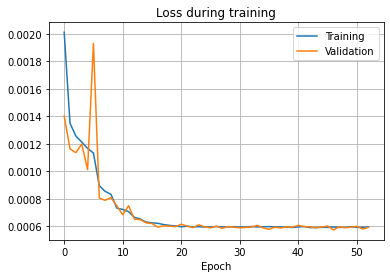

In [ ]:
display_history(history)

Thanks to the huge number of possible elements of the dataset there's no overfitting.

In [ ]:
x, y = next(test_generator)
y_pred = model.predict(x)

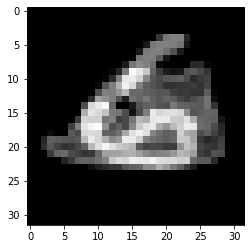

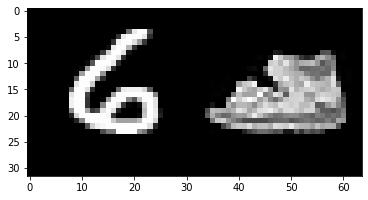

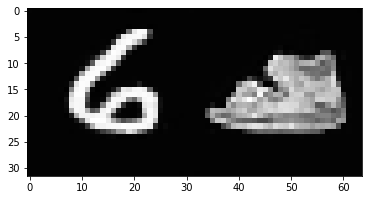

In [ ]:
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

#### Model evaluation

In [ ]:
mse=np.zeros(10)
for i in range(10):
  mse[i]=model.evaluate(test_generator, steps=20000)
mean_mse=mse.mean()
std=mse.std()
print(f'Mean MSE: {mean_mse}\nStandard deviation: {std}')

20000/20000 [==============================] - 115s 6ms/step - loss: 6.0069e-04
Mean MSE: 0.0005957646470051258
Standard deviation: 2.946819337813666e-06
